## Extract marine debris from Sentinel-2

In [21]:
import ee
import geemap
import logging
import multiprocessing
import os
import requests
import shutil
from retry import retry
geemap.set_proxy(port=7890)

In [22]:
import rasterio
import rasterio.plot
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

### Initialize GEE to use the high-volume endpoint

- [high-volume endpoint](https://developers.google.com/earth-engine/cloud/highvolume)

In [23]:
ee.Initialize()

### 漂浮垃圾追踪

In [24]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

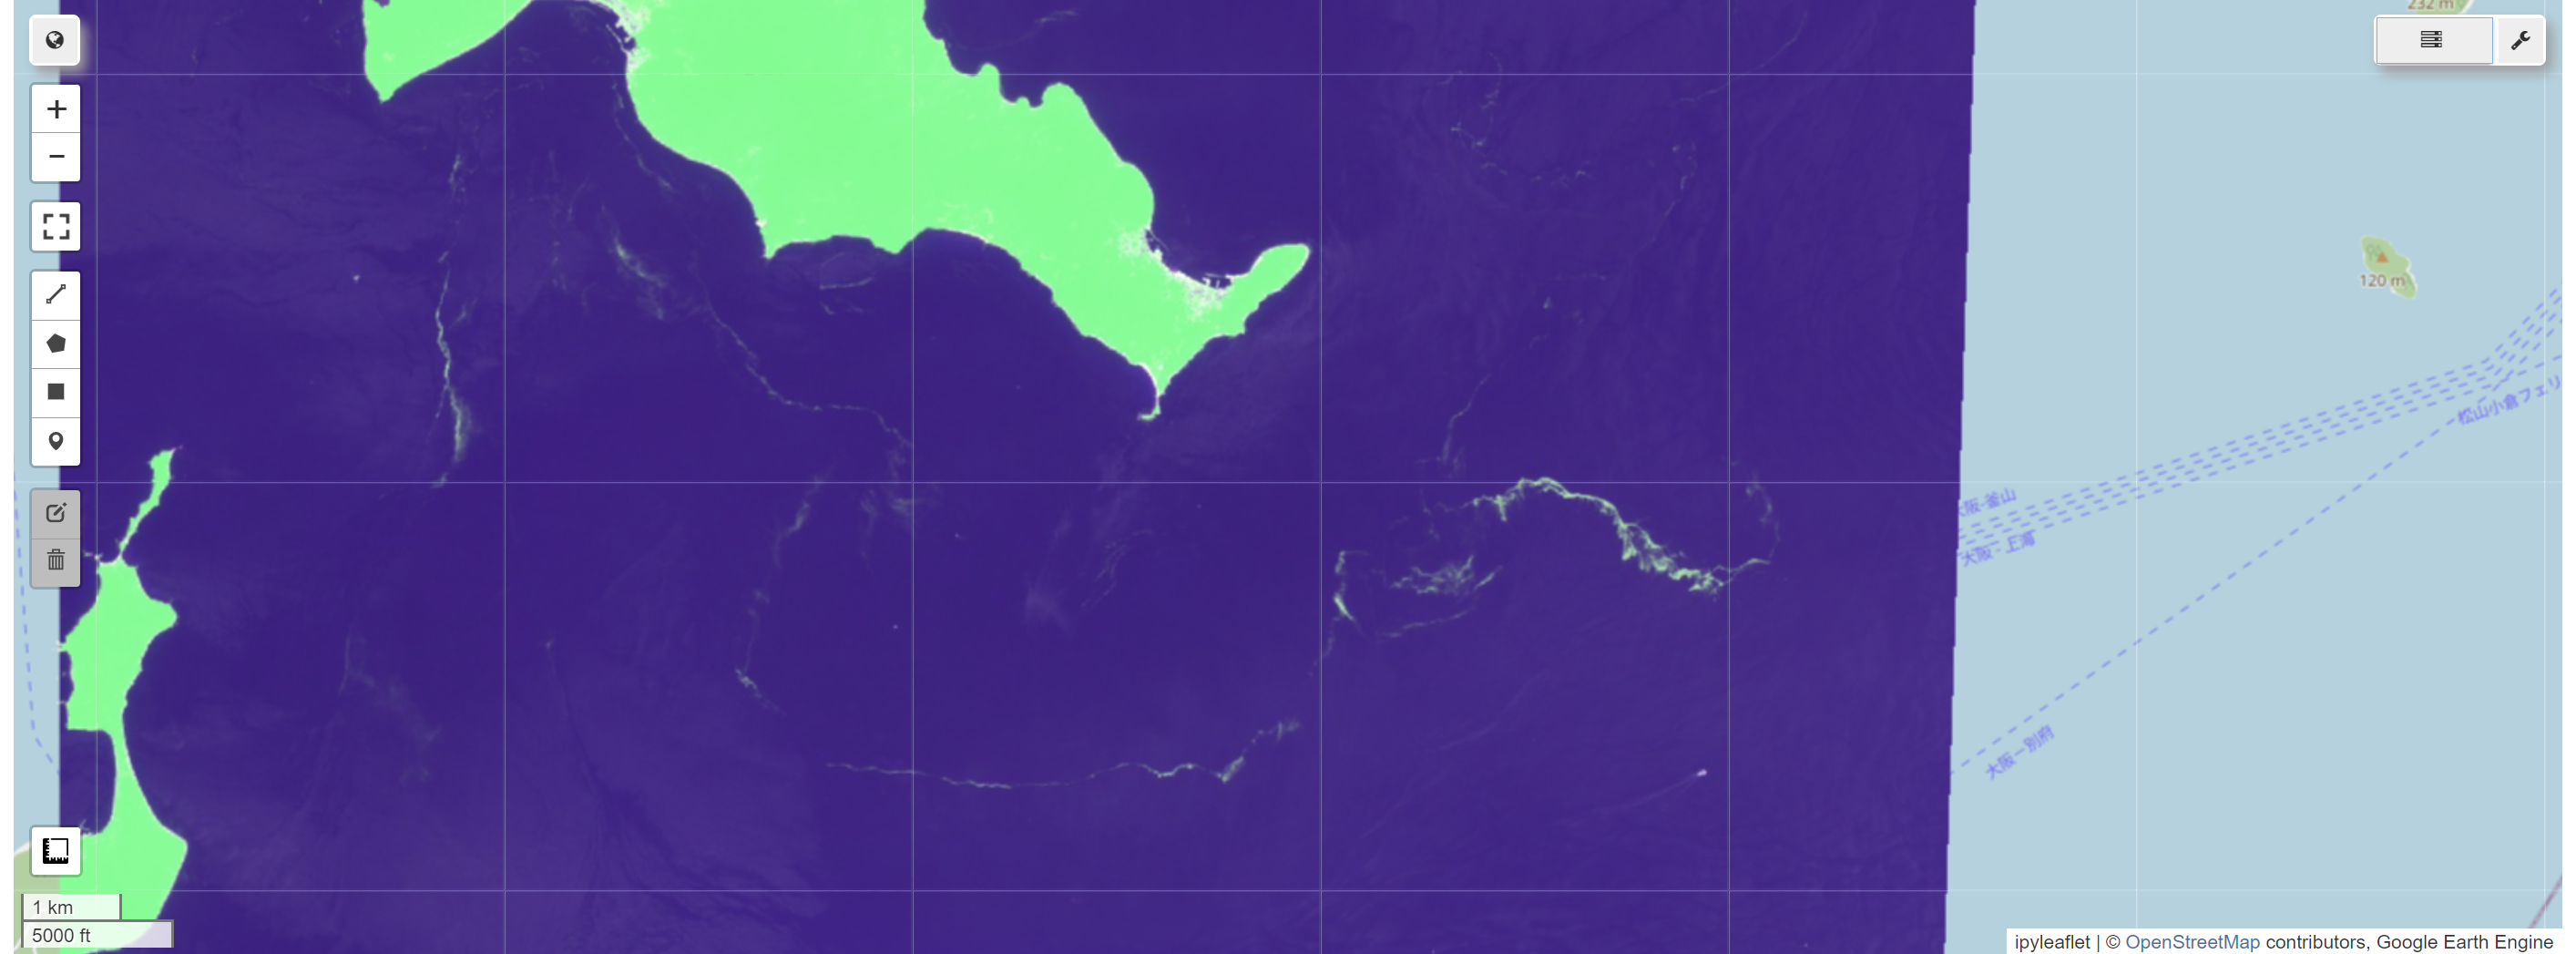

### 设置研究区 Region of Interest (ROI)

You can use the drawing tools on the map to draw an ROI, then you can use `Map.user_roi` to retrieve the geometry. Alternatively, you can define the ROI as an ee.Geometry as shown below.

In [25]:
# region = Map.user_roi
region = ee.Geometry.Polygon([[[132.139569, 33.699657],
  [132.139569, 33.82296],
  [132.404246, 33.82296],
  [132.404246, 33.699657],
  [132.139569, 33.699657]]], None, False)

### 数据源Sentinel 2

Using the 10-m [Sentinel-2 imagery](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#bands).

In [26]:
# image name of the most severe floating garbage incident in Japan every year. 
SystemIndex=[
'20240904T014651_20240904T015206_T52SGB',
'20240907T015651_20240907T020551_T52SGB',
'20240909T014649_20240909T015208_T52SGB',
'20230604T013659_20230604T014516_T53SMT',
'20220805T012659_20220805T013242_T54SUH',
'20210714T013659_20210714T013655_T53SNV',
'20200730T015701_20200730T015658_T52SGC',
'20191028T013751_20191028T013749_T53SPA',
'20191023T013719_20191023T014434_T53SPA',
'20180713T014649_20180713T015739_T52SGC',
'20180723T014649_20180723T015738_T53SKT',
'20180716T015649_20180716T020732_T53SKT',
'20180718T014651_20180718T015206_T53SKT',
'20170926T014639_20170926T015003_T53SLU',
'20170926T014639_20170926T015003_T53SMU',
'20160811T012702_20160811T013103_T54TWL',
'20160811T012702_20160811T050018_T54TWL',
]


## 去云

In [27]:
    #   .copyProperties(image, image.propertyNames())
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )
  mask = mask.Not().fastDistanceTransform().sqrt().gt(15)

  return image.select("B.*").updateMask(mask)


## 邻域差分核心算法

In [28]:
# 定义 DeltaR 函数
def DeltaR(kernel=3):
    def process(image):
        # 计算邻域最小值
        Rmin = image.reduceNeighborhood(
            reducer=ee.Reducer.min(),
            kernel=ee.Kernel.square(kernel)
        )
        # 图像减去邻域最小值
        subtracted = image.subtract(Rmin).regexpRename('^','Diff_')
        # 复制属性并返回结果
        return image.addBands(subtracted).divide(10000).copyProperties(image, image.propertyNames())
    return process
    
# 定义映射函数，提取属性并格式化日期
def extract_properties(image):
    date_str = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    image = image.set({
        'Date': date_str,
        'TargetType': 'Debris',
        'ProductType': 'L1C_TOA',
        'Institution': 'Nanjing University',
        'Author': 'Lu_Group',
    })
    return image
 

### 定位影像

In [29]:
ID = SystemIndex[9]   
S2 = (
    ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
        .filter(ee.Filter.eq('system:index', ID))
        .map(mask_s2_clouds)
        .map(DeltaR(7))
        .map(lambda img: img.addBands(img.normalizedDifference(['Diff_B8', 'Diff_B4']).rename('NDVI')))
)

image = S2.first().clip(region)

### 设置参数

If you want the exported images to have coordinate system, change `format` to `GEO_TIFF`. Otherwise, you can use `png` or `jpg` formats.

In [30]:
params = {
    'count': 100,  # How many image chips to export
    'buffer': 127,  # The buffer distance (m) around each point
    'scale': 10,  # The scale to do stratified sampling
    'seed': 1,  # A randomization seed to use for subsampling.
    'dimensions': '256x256',  # The dimension of each image chip
    'format': "png",  # The output image format, can be png, jpg, ZIPPED_GEO_TIFF, GEO_TIFF, NPY
    'prefix': 'tile_',  # The filename prefix
    'processes': 25,  # How many processes to used for parallel processing
    'out_dir': '.',  # The output directory. Default to the current working directly
}

### 在线添加查看

In [31]:
visFCITOA = {'min': 0.00, 'max': 0.2,'bands':'B4,B8,B2','gamma':1.3}
visDiff = {'min': 0.00, 'max': 0.2,'bands':'Diff_B4,Diff_B8,Diff_B2','gamma':1.3}

Map.addLayer(image, visFCITOA, "Sentinel-2 Debris")
Map.addLayer(image, visDiff, "Sentinel-2 Diff")
Map.addLayer(region, {}, "ROI", False)
Map.centerObject(region, 13)
Map

Map(center=[33.76131725847406, 132.27190749999926], controls=(WidgetControl(options=['position', 'transparent_…

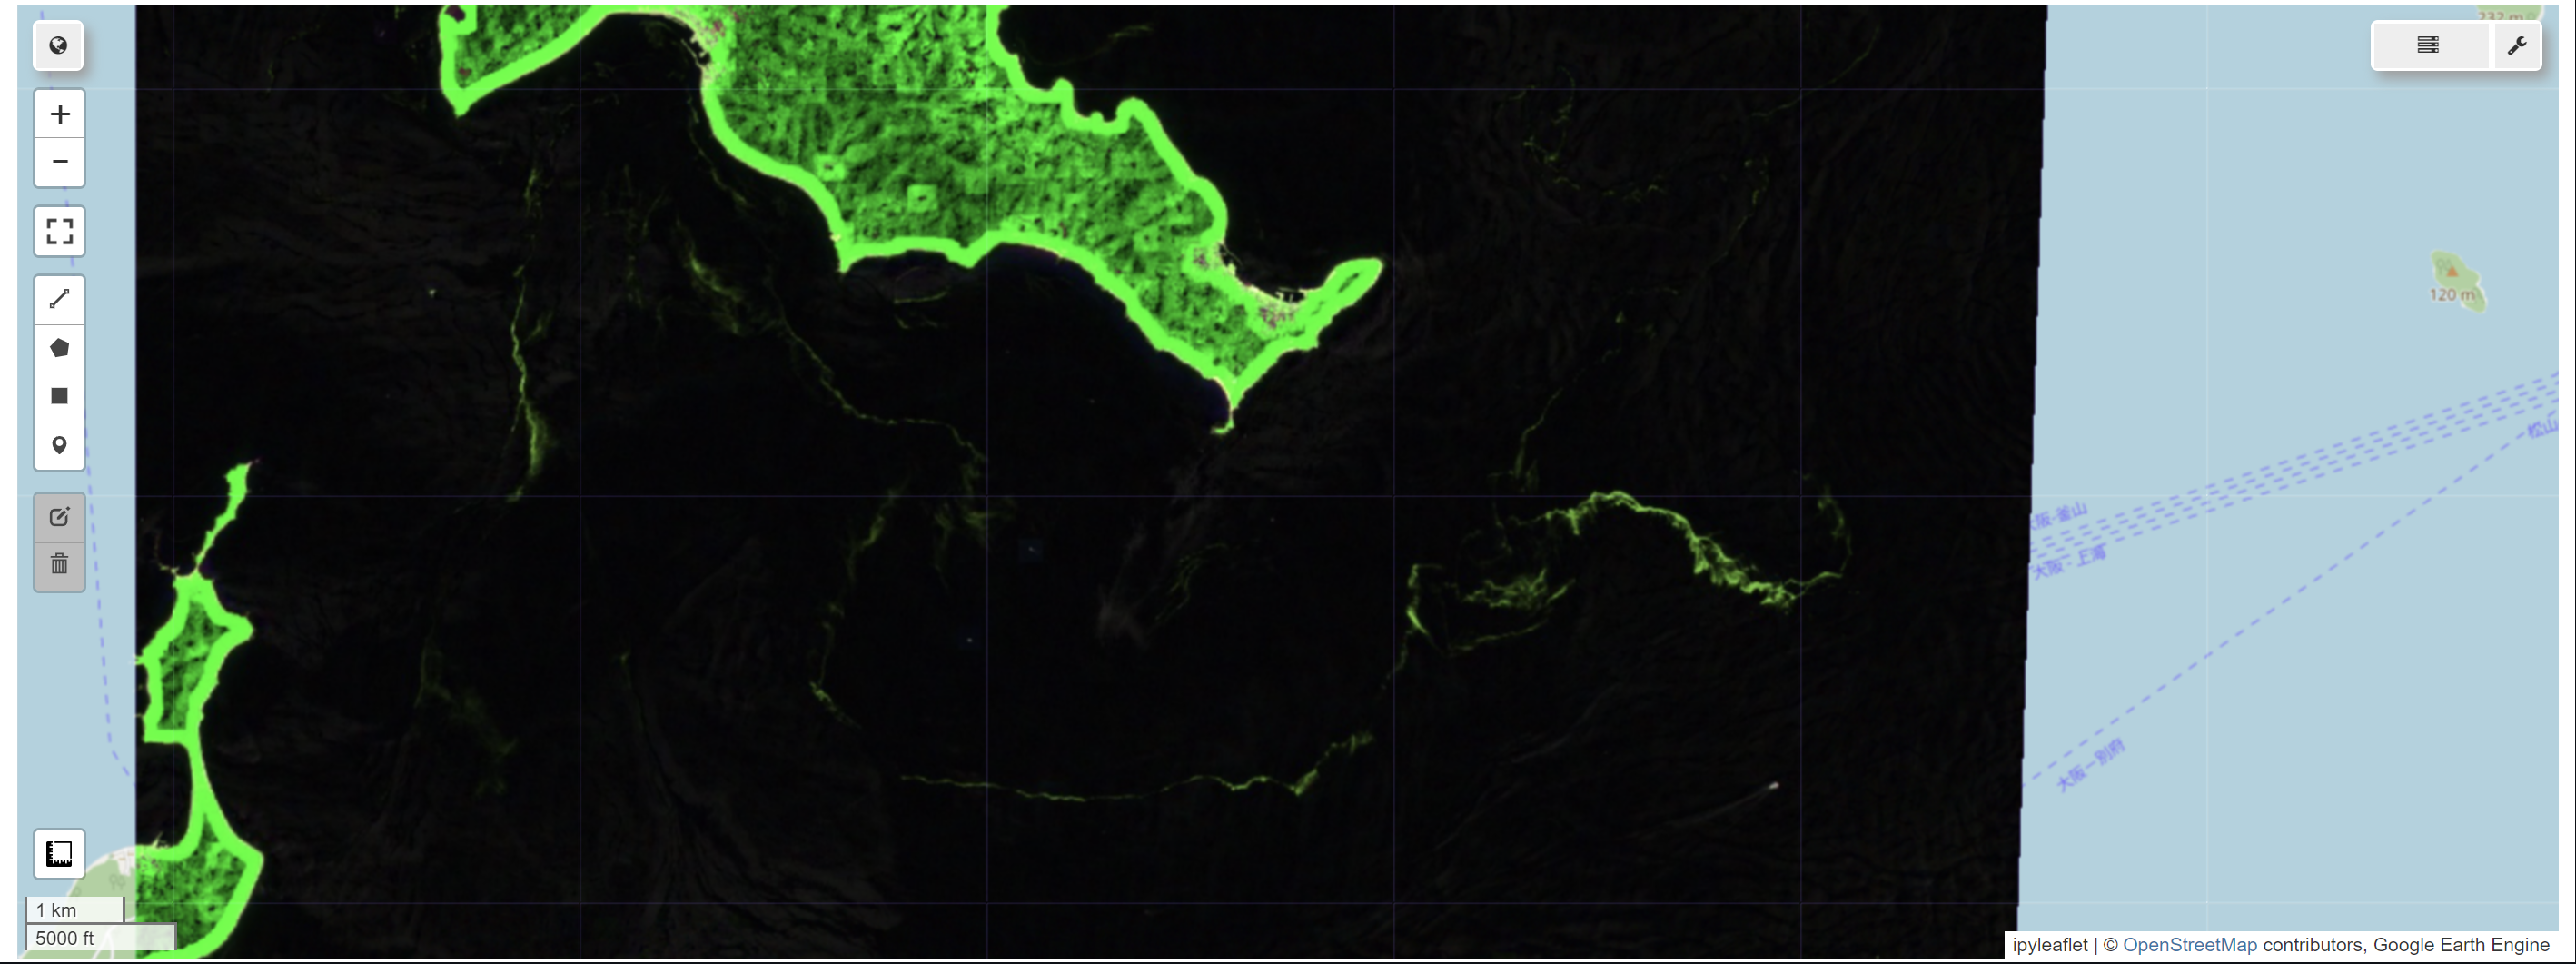

## 本地加载

In [32]:
# 查看当前影像编号
ID

'20180713T014649_20180713T015739_T52SGC'

In [33]:
import os 

sentinal_fp = "../数据/sentinel-2/Chip"
# find every file in the sentinal_fp directory whose basename contains the ID
sentinal_paths = []
for root, dirs, files in os.walk(sentinal_fp):
    for f in files:
        if os.path.isfile(os.path.join(root, f)) and ID in os.path.basename(f):
            sentinal_paths.append(os.path.join(root, f))
DiffR,Label,TOAR = sentinal_paths

In [34]:
DiffR,Label,TOAR 

('../数据/sentinel-2/Chip\\DiffR\\20180713T014649_20180713T015739_T52SGC_10.tif',
 '../数据/sentinel-2/Chip\\Label\\20180713T014649_20180713T015739_T52SGC_10.tif',
 '../数据/sentinel-2/Chip\\R\\20180713T014649_20180713T015739_T52SGC_10.tif')

### 影像元数据

In [35]:
 rasterio.open(TOAR).meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 256,
 'height': 256,
 'count': 13,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.000107531438566566, 0.0, 132.2867557144395,
        0.0, -8.997137087049523e-05, 33.77248985962957)}

### TOA Label Diff 制图分析

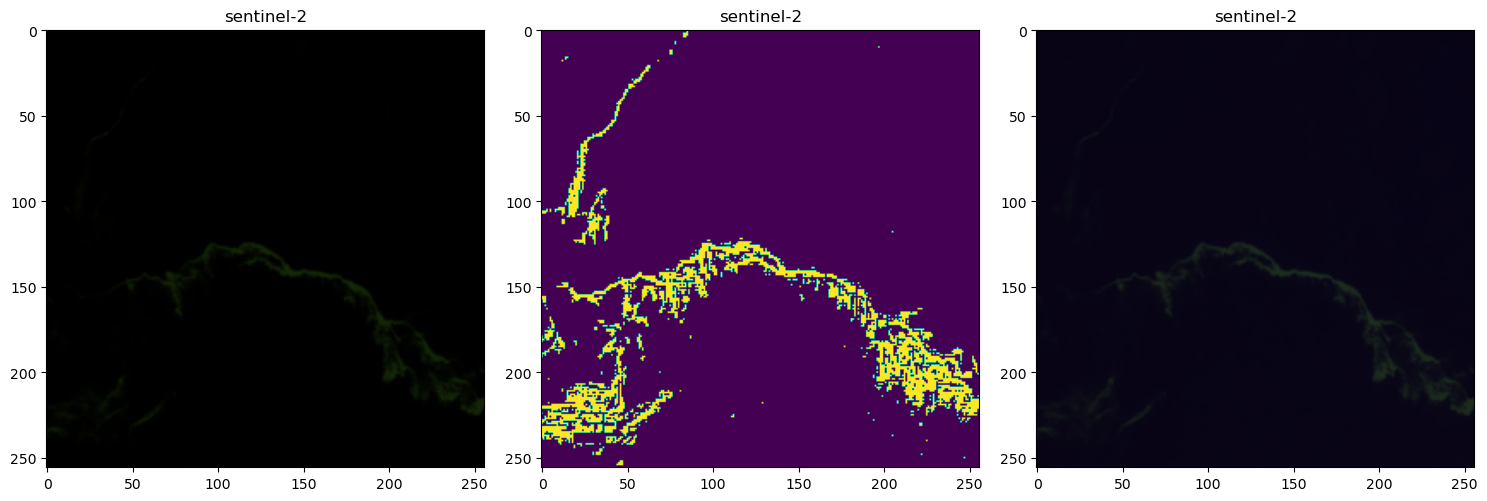

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

for index, img in enumerate(sentinal_paths):
    src = rasterio.open(img)
    if "Label" in img:
        data = src.read(1)
    else:
        data = src.read([4, 8, 2]).transpose(1, 2, 0).clip(0, 1)
    ax = axes[index]
    im = ax.imshow(data)
    ax.set_title(img.split('/')[-2])

# Plot the stacked array
plt.tight_layout()
plt.show()